In [1]:
def LSTM_probe(csv_path: str):
    """
    Reads 'csv_path' data, transforms it and 
    estimates LSTM model quality on first 6 directions.
    """
    
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt  

    from keras.models import Sequential
    from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

    df = pd.read_csv(csv_path, sep=';', index_col='index')[0:6].T

    print(f'Data_shape  = {df.shape}'     + '\n')
    print(f'Data_sample = \n {df.head()}' + '\n')

    def data_prep(data, n_steps_in):
        X, y = list(), list()
        for i in range(len(data)):
            end_idx     = n_steps_in + i
            out_end_idx = end_idx    + 1
            if out_end_idx > len(data):
                break
            seq_x, seq_y = data[i:end_idx,:], data[end_idx:out_end_idx,:]
            X.append(seq_x), y.append(seq_y)
        return np.array(X), np.array(y)

    WINDOW_SIZE = 3
    X, y = data_prep(df.to_numpy(), WINDOW_SIZE)

    FEATURES_NUM = X.shape[2]    
    print(f'X_shape  = {X.shape}')
    print(f'y_shape  = {y.shape}'      + '\n')
    print(f'Features = {FEATURES_NUM}' + '\n')

    def train_valid_split(X, y, frac=0.2):
        sep = int(len(X) * (1.0 - frac))

        X_train, y_train = X[:sep], y[:sep]
        X_valid, y_valid = X[sep:], y[sep:]
        
        return X_train, y_train, X_valid, y_valid

    X_train, \
    y_train, \
    X_valid, \
    y_valid = train_valid_split(X, y)

    def model_prep(inp_shape: tuple):
        model = Sequential([
            LSTM(20, activation='relu', input_shape=inp_shape),
            RepeatVector(1),
            LSTM(20, activation='relu', return_sequences=True),
            TimeDistributed(Dense(inp_shape[1])),
        ])
        return model

    model = model_prep([WINDOW_SIZE, FEATURES_NUM])
    model.compile(optimizer='adam', loss='mae')

    history = model.fit(
        X_train, 
        y_train,
        validation_data=(X_valid, y_valid),
        epochs=25,
        verbose=0)

    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('mae')
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'valid'], loc='upper left')
    
    y_predt = model.predict(X)
    
    ROWS, COLS = 2, 3
    __, ax = plt.subplots(nrows=ROWS, ncols=COLS)
    for i in range(ROWS):
        for j in range(COLS):
            ax[i][j].plot(y.T[i+j][0])
            ax[i][j].plot(np.maximum(0, y_predt.T[i+j][0]))
            ax[i][j].legend(['g_truth', 'predict'])

Data_shape  = (392, 6)

Data_sample = 
 index                956709->956305  ...  967600->960007
2021-03-16 04:01:00            18.0  ...             4.0
2021-03-16 08:01:00             0.0  ...             5.0
2021-03-16 12:01:00             0.0  ...             1.0
2021-03-16 16:01:00             0.0  ...            71.0
2021-03-16 20:01:00             0.0  ...           185.0

[5 rows x 6 columns]

X_shape  = (389, 3, 6)
y_shape  = (389, 1, 6)

Features = 6



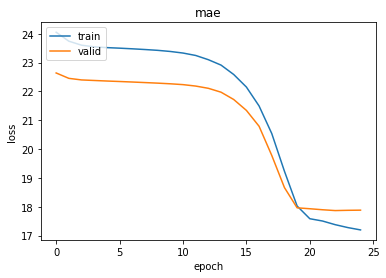

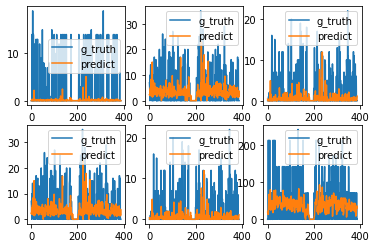

In [2]:
LSTM_probe('table.csv')